## Imports

In [1]:
import os
import pandas as pd
import seaborn as sns
import sys

# Custome functions
sys.path.append('../scripts/python')
from taxonomic_composition_tables import adjust_suthaus_2020_df, prepare_data_for_plotting, plot_taxonomic_data

## Global variables

In [2]:
project = 'Suthaus_2022'
cell = 'cellCombined'
marker = 'Full18S'
sim = 'sim90'
denoise_method = 'RAD'
raw_data = os.path.join('..', 'raw_data')
tax_assign_results = os.path.join(raw_data, 'tax_assign_results', project, marker, cell, sim, denoise_method)
otu_results = os.path.join(raw_data, 'OTU_results', project)

# Creating taxonomic table

In [ ]:
# VARIABLES

project = 'Jamy_2022'
cell = 'cell'
marker = 'rDNA'
sim = 'sim97'
raw_data = '../raw_data'
tax_assign_results =  f'{raw_data}/tax_assign_results/{project}/{marker}/{cell}/{sim}'
otu_results = f'{raw_data}/OTU_results/{project}'

In [ ]:
# get paths

files = os.listdir(tax_assign_results)
paths = [tax_assign_results + '/' + file for file in files]

record = {'otu_id': [], 
          'abundance': [],
          'kingdom': [], 
          'domain': [], 
          'phyllum': [], 
          'class': [], 
          'order': [], 
          'family': [], 
          'genus': [], 
          'species': [], 
          'closest_match': [],
          'percent_identity': [], 
          'sample': []}
    
for path in paths:
    with open(path, 'rt') as f:
        lines = f.readlines()
        for line in lines:
            record['otu_id'].append(line.split('\t')[0])
            record['abundance'].append(line.split('\t')[0].split('=')[-1])
            tax_assign = line.split('\t')[1]
            record['kingdom'].append(tax_assign.split(',')[0].split(':')[1])
            record['domain'].append(tax_assign.split(',')[1].lstrip('d:'))
            record['phyllum'].append(tax_assign.split(',')[2].lstrip('p:'))
            record['class'].append(tax_assign.split(',')[3].lstrip('c:'))
            record['order'].append(tax_assign.split(',')[4].lstrip('o:'))
            record['family'].append(tax_assign.split(',')[5].lstrip('f:'))
            record['genus'].append(tax_assign.split(',')[6].lstrip('g:'))
            record['species'].append(tax_assign.split(',')[7].lstrip('s:'))
            record['closest_match'].append(line.split('\t')[1].split(';')[0].split('.')[0])
            record['percent_identity'].append(line.split('\t')[2])
            record['sample'].append(path.split('/')[-1].lstrip('blast6_').rstrip('.tab'))

        
sum_table = pd.DataFrame.from_dict(record)

In [ ]:
# removing the '_21R' from all the sample names if present (this applied for Suthaus 2022 rDNA data)
sum_table['sample'] = sum_table['sample'].str.replace('_21R','')

In [ ]:
sum_table_filtered = sum_table[sum_table['abundance'] != '1']

In [ ]:
# save the summary table as excel tables

sum_table.to_excel(f'{otu_results}/OTU_summary_table_{marker}_{cell}_{sim}.xlsx')

In [ ]:
# save the summary table as tsv tables

sum_table.to_csv(f'{otu_results}/OTU_summary_table_{marker}_{cell}_{sim}.tsv', sep = '\t')

In [ ]:
# save the filtered summary table as tsv tables

sum_table_filtered.to_csv(f'{otu_results}/OTU_summary_table_{marker}_{cell}_{sim}_filtered.tsv', sep = '\t')

# Creating final taxonomic table

## DataFrame

Read all the files from the tax_assign_results directory and concatenate them into a single DataFrame

In [ ]:
# 1. List all files in the directory
files = [f for f in os.listdir(tax_assign_results) if f.endswith('.tab')]

# 2. Iterate over each file
dfs = []

for f in files:
    # extract sample name
    sample_name = f.split('_')[1]
    # Load file into DataFrame
    df = pd.read_csv(f'{tax_assign_results}/{f}', sep='\t', header=None)
    # Add a new column for sample name
    df['Sample'] = sample_name
    dfs.append(df)

# 3. Concatenate all DataFrames
all_samples = pd.concat(dfs, ignore_index=True)

# 4. Dataframe adjustments
all_samples = adjust_suthaus_2020_df(all_samples)

In [ ]:
all_samples.head(5)

In [ ]:
all_samples['Sample'].unique()

In [ ]:
# Save the DataFrame to CSV
output_filename = f'final_tax_table_{marker}_{sim}.csv'
output_path = os.path.join(otu_results, output_filename)

all_samples.to_csv(output_path, index=False)

# Taxonomic composition plots

## Variables

In [ ]:
grouping = 'unique_otus' # Options: 'unique_otus' or 'abundances'
taxonomic_level = 'Class' # Taxonomic level for the plotting
threshold_percentage = 0 # Set the percentage treshold based on what the tax. groups will be grouped together as 'Others'
save_path = os.path.join(otu_results, f'tax_composition_{taxonomic_level}_{grouping}_{marker}_{sim}.png')
load_data_path = os.path.join(otu_results, f'final_tax_table_{marker}_{sim}.csv')

# Define the new sample names if you want to change it in the plot
sample_name_mapping = {'deep_sea_A3': 'Deep Sea A3', 
                       'deep_sea_X17007': 'Deep Sea X17007', 
                       'NH1': 'Neuenhähnen 1', 
                       'NH4': 'Neuenhähnen 4', 
                       'Sim17': 'Simmelried 17', 
                       'Sim22': 'Simmelried 22', 
                       'Th16': 'Thielenbruch 16', 
                       'Th38': 'Thielenbruch 38',
                       'Th40': 'Thielenbruch 40',}

## Loading data

In [ ]:
all_samples = pd.read_csv(load_data_path)

## Filtering out unwanted samples and taxonomic groups

In [ ]:
# Filter out the 'Mock' sample, 'Bacteria_X' domain, and 'Metazoa' phyllum
filtered_samples = all_samples[(all_samples['Sample'] != 'Mock') 
                               & (all_samples['Domain'] != 'Bacteria_X') 
                               & (all_samples['Phyllum'] != 'Metazoa')]

## Preparing data for plotting

In [ ]:
# Preparing data for plotting
pivot_table, excluded_columns = prepare_data_for_plotting(dataframe = filtered_samples, 
                                                          taxonomic_level = taxonomic_level, 
                                                          threshold_percentage = threshold_percentage, grouping = grouping)

## Plotting & Saving

In [ ]:
plot_taxonomic_data(pivot_table, 
                    excluded_columns, 
                    taxonomic_level = taxonomic_level, 
                    grouping= grouping, 
                    sample_name_mapping = sample_name_mapping,
                    save_path = False)

# Taxonomic composition plots: Subgrouping

Examining taxonomic composition within a specific group

## Variables

In [ ]:
all_samples

In [ ]:
all_samples['Phyllum'].unique()

In [3]:
grouping = 'unique_otus' # Options: 'unique_otus' or 'abundances'
taxonomic_level = 'Species' # Taxonomic level for the plotting
threshold_percentage = 2 # Set the percentage treshold based on what the tax. groups will be grouped together as 'Others'

# Subgrouping Option:
# If you wish to further examine the taxonomic composition within a specific group, 
# provide the specific taxa and its corresponding taxonomic level.
taxa_specific = 'Armophorea' 
taxa_specific_level = 'Class' 

load_data_path = os.path.join(otu_results, f'final_tax_table_{marker}_{sim}.csv')
save_path = os.path.join(otu_results, f'tax_composition_{taxonomic_level}_{grouping}_{marker}_{sim}_{taxa_specific}.png')

# Define the new sample names if you want to change it in the plot
sample_name_mapping = {'deep_sea_A3': 'Deep Sea A3', 
                       'deep_sea_X17007': 'Deep Sea X17007', 
                       'NH1': 'Neuenhähnen 1', 
                       'NH4': 'Neuenhähnen 4', 
                       'Sim17': 'Simmelried 17', 
                       'Sim22': 'Simmelried 22', 
                       'Th16': 'Thielenbruch 16', 
                       'Th38': 'Thielenbruch 38',
                       'Th40': 'Thielenbruch 40',}

## Loading data

In [4]:
all_samples = pd.read_csv(load_data_path)

## Selecting specific taxonomic group

In [5]:
# Filter the samples based on the specified taxonomic group and its level.
subgrouped_samples = all_samples[all_samples[taxa_specific_level] == taxa_specific]

## Filtering out unwanted samples and taxonomic groups

In [6]:
# Filter out the 'Mock' sample, 'Bacteria_X' domain, and 'Metazoa' phyllum
filtered_samples = subgrouped_samples[(subgrouped_samples['Sample'] != 'Mock') 
                                      & (subgrouped_samples['Domain'] != 'Bacteria_X') 
                                      & (subgrouped_samples['Phyllum'] != 'Metazoa')]

## Preparing data for plotting

In [7]:
# Preparing data for plotting
pivot_table, excluded_columns = prepare_data_for_plotting(dataframe = filtered_samples, 
                                                          taxonomic_level = taxonomic_level, 
                                                          threshold_percentage = threshold_percentage, grouping = grouping)

## Plotting

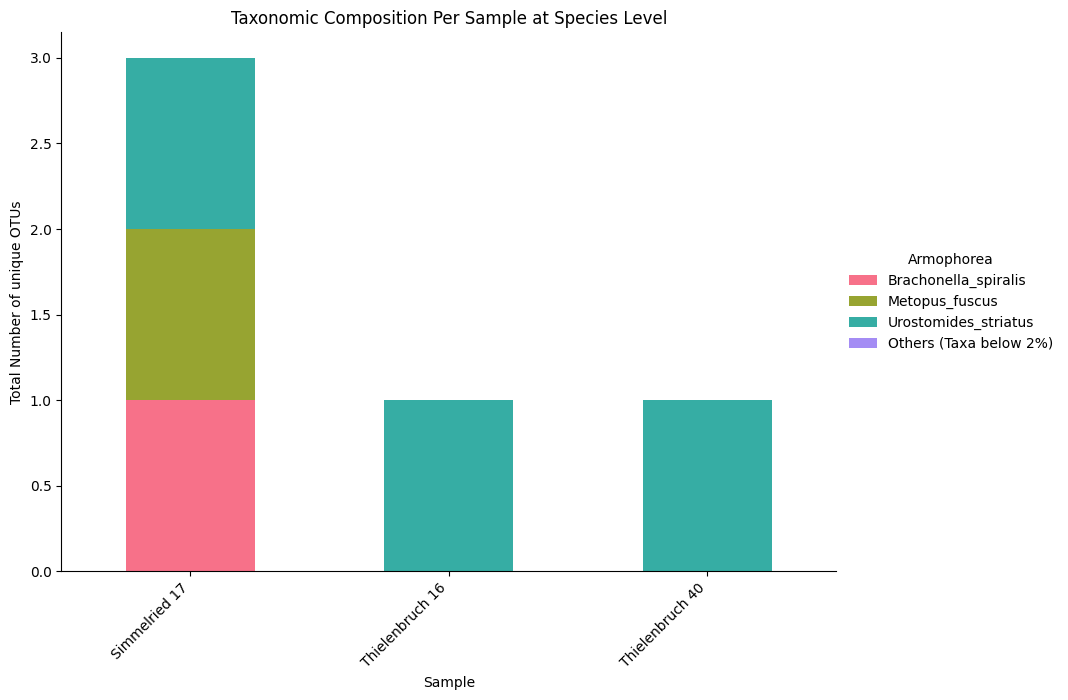

In [8]:
plot_taxonomic_data(pivot_table, 
                    excluded_columns, 
                    taxonomic_level = taxonomic_level, 
                    grouping= grouping, 
                    sample_name_mapping = sample_name_mapping,
                    save_path = False, 
                    subgroup = taxa_specific)